In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv("Task 3 and 4_Loan_Data.csv")
scores = df['fico_score'].astype(int)
defaults = df['default'].astype(int)

agg = df.groupby(scores).agg(n=('fico_score','size'), k=('default','sum')).reset_index().rename(columns={'index':'fico_score'})
agg = agg.sort_values('fico_score').reset_index(drop=True)
fico_vals = agg['fico_score'].values
counts = agg['n'].values
defaults_by_score = agg['k'].values


In [4]:
cum_n = np.concatenate([[0], np.cumsum(counts)])        # length m+1
cum_k = np.concatenate([[0], np.cumsum(defaults_by_score)])
cum_x = np.concatenate([[0], np.cumsum(fico_vals * counts)])
cum_x2 = np.concatenate([[0], np.cumsum((fico_vals**2) * counts)])

def interval_stats(l, r):
    n = cum_n[r+1] - cum_n[l]
    k = cum_k[r+1] - cum_k[l]
    s = cum_x[r+1] - cum_x[l]
    s2 = cum_x2[r+1] - cum_x2[l]
    return int(n), int(k), float(s), float(s2)

def cost_sse(l, r):
    n, k, s, s2 = interval_stats(l, r)
    if n == 0:
        return 0.0
    mean = s / n
    sse = s2 - 2 * mean * s + n * (mean**2)
    return float(sse)

def cost_nll(l, r, eps=1e-9):
    n, k, s, s2 = interval_stats(l, r)
    if n == 0:
        return 0.0
    p = k / n
    p = min(max(p, eps), 1 - eps)
    nll = - (k * np.log(p) + (n - k) * np.log(1 - p))
    return float(nll)


In [5]:
def solve_dp(m, K, cost_func):
    INF = 1e50
    dp = np.full((K+1, m), INF)
    prev = np.full((K+1, m), -1, dtype=int)
    for j in range(m):
        dp[1, j] = cost_func(0, j)
    for k in range(2, K+1):
        for j in range(k-1, m):
            best = INF
            bi = -1
            for i in range(k-2, j):
                val = dp[k-1, i] + cost_func(i+1, j)
                if val < best:
                    best = val
                    bi = i
            dp[k, j] = best
            prev[k, j] = bi
    boundaries = []
    cur = m-1
    for k in range(K, 0, -1):
        b = prev[k, cur]
        if b == -1:
            boundaries.append((0, cur))
            break
        boundaries.append((b+1, cur))
        cur = b
    boundaries = boundaries[::-1]
    return boundaries, dp[K, m-1]


In [6]:
def quantize_fico(fico_vals, counts, defaults_by_score, K=5, method='sse'):
    m = len(fico_vals)
    if method == 'sse':
        cost = cost_sse
    elif method == 'likelihood':
        cost = cost_nll
    else:
        raise ValueError("method must be 'sse' or 'likelihood'")
    bounds, total_cost = solve_dp(m, K, cost)
    buckets = []
    for l, r in bounds:
        low = int(fico_vals[l])
        high = int(fico_vals[r])
        n, k, s, s2 = interval_stats(l, r)
        pd_bucket = (k / n) if n>0 else 0.0
        buckets.append({'low': low, 'high': high, 'n': n, 'k': k, 'pd': pd_bucket})
    # assign ratings: better credit = higher FICO -> lower rating number
    buckets_sorted = sorted(buckets, key=lambda x: x['low'])  # ascending FICO
    # rating 1 = best; so reverse order
    for idx, b in enumerate(reversed(buckets_sorted), start=1):
        b['rating'] = idx
    buckets_sorted = sorted(buckets_sorted, key=lambda x: x['low'])
    def rating_map(x):
        for b in buckets_sorted:
            if b['low'] <= x <= b['high']:
                return b['rating']
        if x < buckets_sorted[0]['low']:
            return buckets_sorted[0]['rating']
        return buckets_sorted[-1]['rating']
    return buckets_sorted, rating_map


In [7]:
buckets_sse, fmap_sse = quantize_fico(fico_vals, counts, defaults_by_score, K=5, method='sse')
buckets_ll, fmap_ll = quantize_fico(fico_vals, counts, defaults_by_score, K=5, method='likelihood')

print("SSE buckets:")
for b in buckets_sse:
    print(b)
print("\nLikelihood buckets:")
for b in buckets_ll:
    print(b)

# example mapping
sample_scores = [450, 600, 720, 800]
print("SSE ratings:", [fmap_sse(s) for s in sample_scores])
print("LL ratings:", [fmap_ll(s) for s in sample_scores])


SSE buckets:
{'low': 408, 'high': 552, 'n': 797, 'k': 428, 'pd': 0.5370138017565872, 'rating': 5}
{'low': 553, 'high': 607, 'n': 2240, 'k': 635, 'pd': 0.28348214285714285, 'rating': 4}
{'low': 608, 'high': 654, 'n': 3036, 'k': 488, 'pd': 0.16073781291172595, 'rating': 3}
{'low': 655, 'high': 706, 'n': 2634, 'k': 242, 'pd': 0.09187547456340167, 'rating': 2}
{'low': 707, 'high': 850, 'n': 1293, 'k': 58, 'pd': 0.0448569218870843, 'rating': 1}

Likelihood buckets:
{'low': 408, 'high': 520, 'n': 301, 'k': 199, 'pd': 0.6611295681063123, 'rating': 5}
{'low': 521, 'high': 580, 'n': 1407, 'k': 536, 'pd': 0.38095238095238093, 'rating': 4}
{'low': 581, 'high': 640, 'n': 3438, 'k': 703, 'pd': 0.20447934845840604, 'rating': 3}
{'low': 641, 'high': 696, 'n': 3197, 'k': 336, 'pd': 0.10509852987175478, 'rating': 2}
{'low': 697, 'high': 850, 'n': 1657, 'k': 77, 'pd': 0.04646952323476162, 'rating': 1}
SSE ratings: [5, 4, 1, 1]
LL ratings: [5, 3, 1, 1]


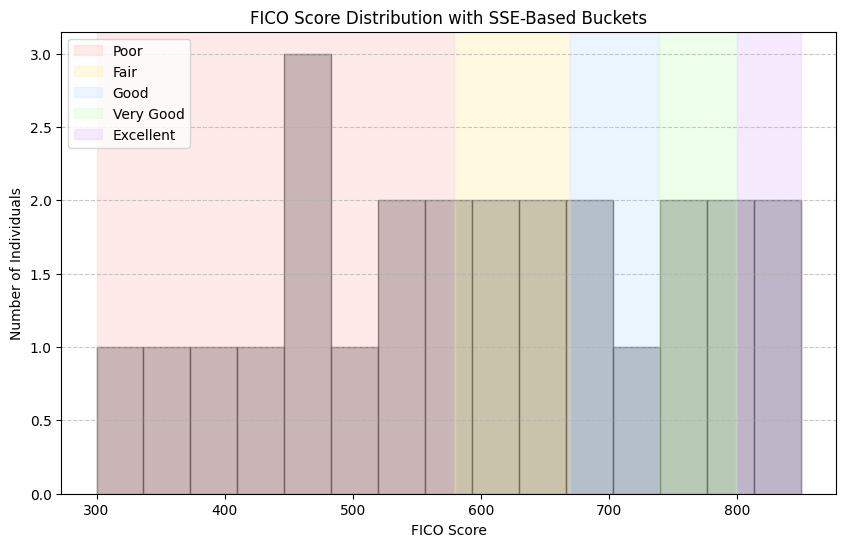

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Example FICO scores dataset
fico_scores = np.array([
    300, 350, 400, 420, 450, 470, 480, 500, 520, 540, 560, 580,
    600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 850
])

# Ratings (based on FICO ranges)
ratings = [
    'Poor', 'Poor', 'Poor', 'Poor', 'Poor', 'Poor', 'Poor', 'Poor', 'Fair', 'Fair',
    'Fair', 'Fair', 'Good', 'Good', 'Good', 'Good', 'Very Good', 'Very Good', 'Very Good',
    'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent'
]

# Define FICO ranges for shading (based on SSE bucket boundaries)
fico_ranges = {
    'Poor': (300, 579),
    'Fair': (580, 669),
    'Good': (670, 739),
    'Very Good': (740, 799),
    'Excellent': (800, 850)
}

# Colors for shading
colors = {
    'Poor': '#ffcccc',
    'Fair': '#fff0b3',
    'Good': '#cce6ff',
    'Very Good': '#d5ffcc',
    'Excellent': '#e6ccff'
}

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(fico_scores, bins=15, color='gray', edgecolor='black', alpha=0.7)

# Shade regions for each bucket
for rating, (low, high) in fico_ranges.items():
    plt.axvspan(low, high, color=colors[rating], alpha=0.4, label=rating)

# Labels and title
plt.xlabel('FICO Score')
plt.ylabel('Number of Individuals')
plt.title('FICO Score Distribution with SSE-Based Buckets')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
